In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import seaborn.objects as so

from scipy.stats import f_oneway
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colors as mcolors
import math

from xlutils.copy import copy  # For modifying .xls files
import xlrd
import xlwt

import statistics

In [2]:
file_path_1= '/Users/taofeek/Documents/Python/Mobile Biometrics Project/Project/trained on augmented data/results_original.csv'
file_path_2 = '/Users/taofeek/Documents/Python/Mobile Biometrics Project/Project/results_voice.csv'

In [3]:
df_face = pd.read_csv(file_path_1)
df_voice = pd.read_csv(file_path_2)

In [4]:
# Group by 'True_Label' and calculate the mean for each group
df_voice = df_voice.groupby('True Label', as_index=False).mean()

In [5]:
# Merge the datasets on 'True_Label'
df_fused = pd.merge(df_face, df_voice, on='True Label', suffixes=('', '_avg'))

# Add the averages only for the matching labels in each row
for index, row in df_fused.iterrows():
    label = str(int(row['True Label']))  # Get the current label as a string
    df_fused.at[index, label] = row[label] + row[f"{label}_avg"]  # Update the matching label column

# Drop the '_avg' columns after updating
columns_to_keep = df_face.columns
avg_columns = [f"{col}" for col in df_fused.columns if col not in df_face.columns]
df_fused = df_fused.drop(columns=avg_columns)

#APPLY SOFTMAX 

In [7]:
# Identify score columns (all except 'True_Label' and 'Predicted_Label')
score_columns = [col for col in df_fused.columns if col not in ['True Label', 'Predicted Label']]

# Apply softmax row-wise
def softmax(row):
    scores = row[score_columns].values  # Extract scores as NumPy array
    exp_scores = np.exp(scores - np.max(scores))  # Subtract max for numerical stability
    return exp_scores / exp_scores.sum()

# Create a new DataFrame with softmax-applied scores
softmax_scores = df_fused[score_columns].apply(softmax, axis=1)

# Update the original DataFrame with softmax scores
df_fused[score_columns] = pd.DataFrame(softmax_scores.tolist(), columns=score_columns)

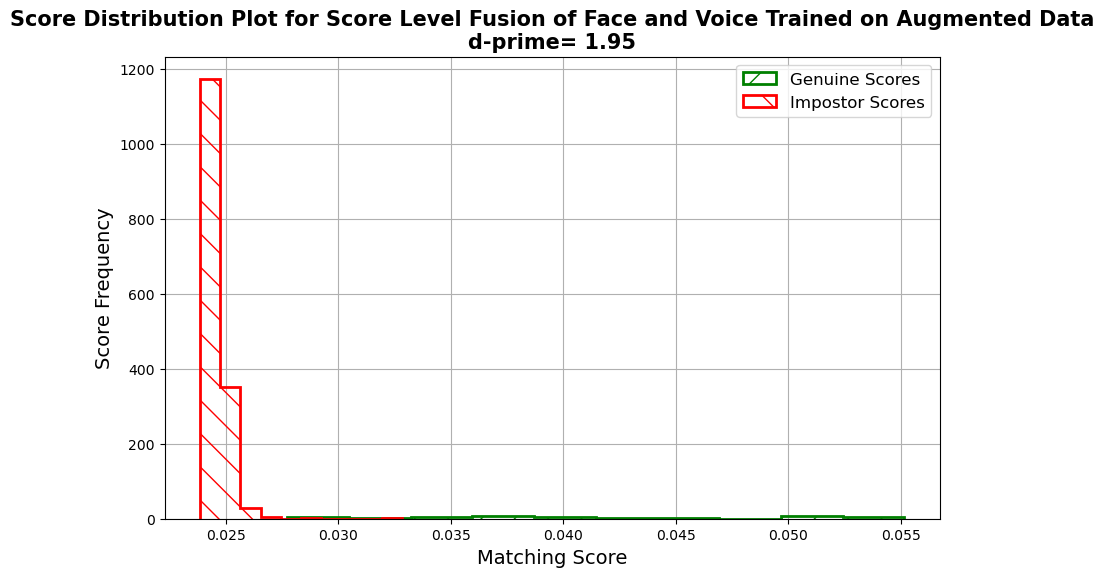

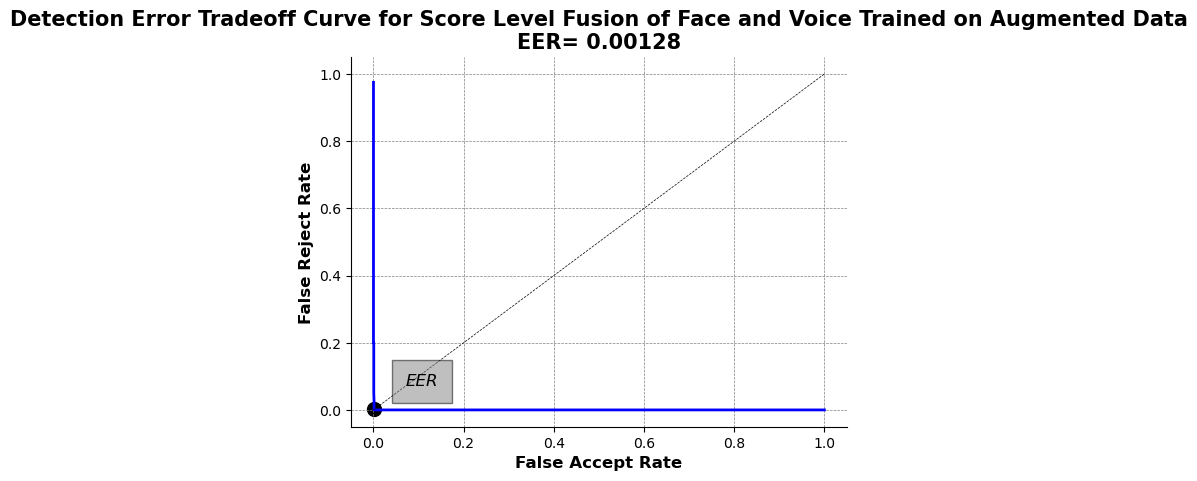

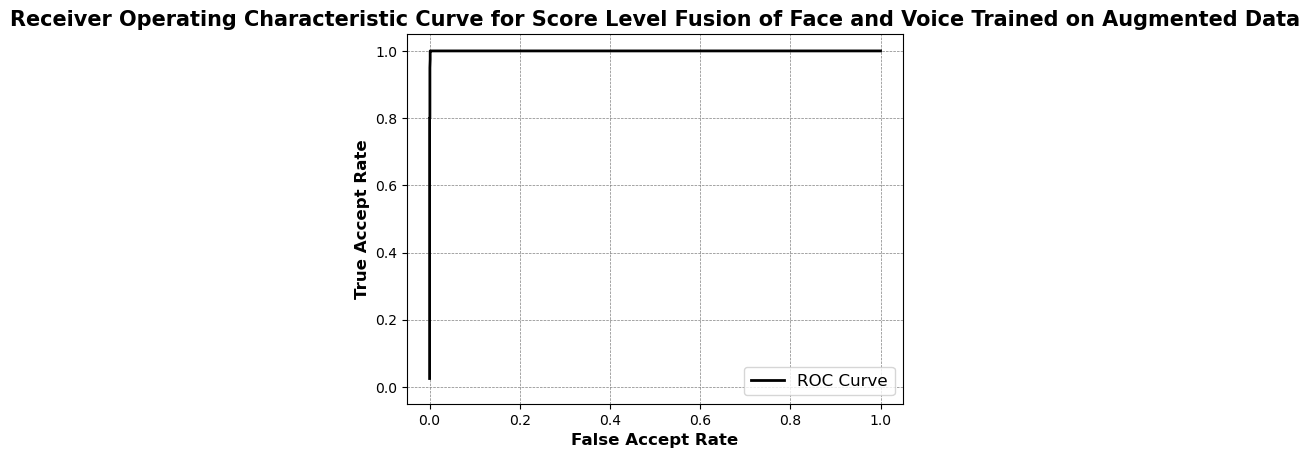

In [17]:
# Step 1: Initialize lists to hold scores
genuine_scores = []
impostor_scores = []
all_scores = []
# Step 2: Extract column labels for scores (assuming they are numerical)
score_columns = df_fused.columns[2:]  # From the third column onwards
# Step 3: Classify scores as genuine or impostor
for index, row in df_fused.iterrows():
    actual_user = int(row['True Label'])  # Convert actual user to integer (label)
    predicted_user = int(row['Predicted Label'])  # Convert predicted user to integer (label)
    
    # Genuine score: Score in the column corresponding to the actual user
    genuine_score = row[str(actual_user)]
    genuine_scores.append(genuine_score)
    all_scores.append(genuine_score)
    
    # Impostor scores: All other scores in the row
    for column in score_columns:
        if int(column) != actual_user:  # Skip the column for the genuine score
            impostor_scores.append(row[column])
            all_scores.append(row[column])


epsilon = 1e-12

mean_genuine = np.mean(genuine_scores)
mean_impostor = np.mean(impostor_scores)
std_genuine = np.std(genuine_scores)
std_impostor = np.std(impostor_scores)
        
d_prime = (mean_genuine - mean_impostor) / np.sqrt((std_genuine**2 + std_impostor**2) + epsilon)
            
# Step 4: Plot the distributions with Matplotlib

# Create a figure
plt.figure(figsize=(10, 6))

# Histogram for genuine scores
plt.hist(
    genuine_scores, lw=2, histtype='step', color='green', label='Genuine Scores', hatch="/"
)

# Histogram for impostor scores
plt.hist(
    impostor_scores, lw=2, histtype='step', color='red', label='Impostor Scores', hatch="\\"
)
# Add titles and labels
plt.title("Score Distribution Plot for Score Level Fusion of Face and Voice Trained on Augmented Data\nd-prime= %.2f" % 
                  (d_prime),
                  fontsize=15,
                  weight="bold")
plt.xlabel('Matching Score', fontsize=14)
plt.ylabel('Score Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

#save plot
plt.savefig("SDP_Fusion_Trained.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()
#close the plot
plt.close()

thresholds = np.linspace(min(all_scores), max(all_scores), 100)

# Convert list to a NumPy array
genuine_scores_array = np.array(genuine_scores)
impostor_scores_array = np.array(impostor_scores)

# Initialize TPR, FPR and FNR lists
TPR, FNR, FPR = [],[],[]

# Calculate FAR and FRR at each threshold
for threshold in thresholds:
    tp = np.sum(genuine_scores_array>=threshold)
    fn = np.sum(genuine_scores_array<threshold)
    fp = np.sum(impostor_scores_array>=threshold)
    tn = np.sum(impostor_scores_array<threshold)

    FPR.append(fp/(fp+tn+epsilon))
    FNR.append(fn/(tp+fn+epsilon))
    TPR.append(tp/(tp+fn+epsilon))
    
EER = FPR[np.nanargmin(np.absolute((np.array(FPR)-np.array(FNR))))]

plt.figure()
plt.plot(FPR, FNR, lw=2, color='blue')

plt.text(EER +0.07,EER+0.07,"EER",style='italic', fontsize=12, bbox={"facecolor":"grey","alpha":0.5,"pad":10})
plt.plot([0,1],[0,1],"--",lw=0.5,color="black")
plt.scatter([EER], [EER], c='black', s=100)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(color="gray",linestyle="--", linewidth=0.5)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlabel("False Accept Rate", fontsize=12, weight="bold")
plt.ylabel("False Reject Rate", fontsize=12, weight="bold")

plt.title("Detection Error Tradeoff Curve for Score Level Fusion of Face and Voice Trained on Augmented Data\nEER= %.5f" % (EER),fontsize=15, weight="bold")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#save plot
plt.savefig("DET_Fusion_Trained.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()
#close the plot
plt.close()

plt.figure()
plt.plot(FPR, TPR, lw=2, color = "black", label="ROC Curve")
# plt.plot([0,1],[0,1],"--", color="grey")

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("False Accept Rate", fontsize=12, weight="bold")
plt.ylabel("True Accept Rate", fontsize=12, weight="bold")

plt.title("Receiver Operating Characteristic Curve for Score Level Fusion of Face and Voice Trained on Augmented Data",fontsize=15, weight="bold")

plt.legend(loc="lower right", fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5)

#save plot
plt.savefig("ROC_Fusion_Trained.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()
#close the plot
plt.close()